In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import glob 
from sunpy.time import parse_time 
from sunpy import timeseries as ts 
import datetime
from matplotlib import dates
from scipy.signal import savgol_filter

In [2]:

vlf_flares = pd.read_csv("final_paper_vlf_flares.csv")
vlf_flares["event_starttime"] = pd.to_datetime(vlf_flares["event_starttime"])


In [3]:
def calc_amp(x):
    return 20*np.log10(x + 5) - 61 + 107

def sid_to_series(file, amp=False):

    sid = pd.read_csv(file, comment="#", names=["times", "data"])
    tt = parse_time(sid["times"]).datetime
    if amp:
        ser = pd.Series(calc_amp(sid["data"].values), index=tt)
    else:
        ser = pd.Series(sid["data"].values, index=tt)       
    ser.sort_index(inplace=True)
    return ser

In [4]:

# File patterns
sid_file_dir = "/Users/laurahayes/ionospheric_work/vlf_data_all_birr/sid_alll/*%Y%m%d*NAA*"
goes_file_dir = "/Users/laurahayes/QPP/stats_study/TEBBS/goes_rawdata/*%Y%m%d*.fits"


def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)


def test_ser(i):
    new_ts = pd.to_datetime(vlf_flares["event_starttime"].iloc[i])-datetime.timedelta(minutes=5)
    new_te = pd.to_datetime(vlf_flares["event_endtime"].iloc[i])+datetime.timedelta(minutes=5)

    # SID data
    sid_file = glob.glob(vlf_flares.iloc[i]["event_starttime"].strftime(sid_file_dir))[0]
    sid_data = sid_to_series(sid_file).truncate(new_ts, new_te)
    sid_data_db = sid_to_series(sid_file, amp=True).truncate(new_ts, new_te)

    return sid_data_db

In [5]:
def signaltonoise_dB(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))

9.700038980450223


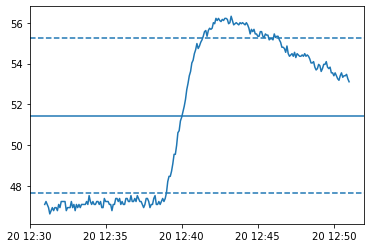

In [6]:
data = test_ser(15)


plt.plot(data)

ax = plt.gca()

plt.axhline(np.mean(data))
plt.axhline(np.mean(data)+np.std(data), ls="dashed")
plt.axhline(np.mean(data)-np.std(data), ls="dashed")

print(np.max(data) - np.min(data))

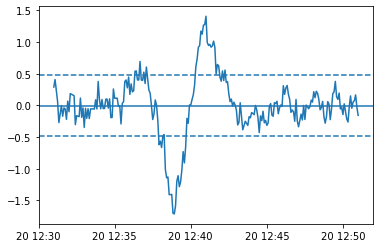

In [7]:
data2 = data - savgol_filter(data, 101, 3)
plt.plot(data2)

ax = plt.gca()

plt.axhline(np.mean(data2))
plt.axhline(np.mean(data2)+np.std(data2), ls="dashed")
plt.axhline(np.mean(data2)-np.std(data2), ls="dashed")

In [8]:
10*np.std(data2)

4.832440238519132

In [9]:
print(np.std(data[0:100]))

0.28447206091728067


In [10]:
signaltonoise_dB(data[0:-1])

22.642191206646608

In [11]:
snr_smo = signaltonoise(savgol_filter(data, 101, 3), ddof=2)
snr = signaltonoise(data, ddof=2)

In [12]:
print(snr, snr_smo)

13.523466540017642 13.850226846564327


## Plot examples

In [13]:
def plot_flare(i):
    new_ts = pd.to_datetime(vlf_flares["event_starttime"].iloc[i])-datetime.timedelta(minutes=5)
    new_te = pd.to_datetime(vlf_flares["event_endtime"].iloc[i])+datetime.timedelta(minutes=5)

    # SID data
    sid_file = glob.glob(vlf_flares.iloc[i]["event_starttime"].strftime(sid_file_dir))[0]
    sid_data = sid_to_series(sid_file).truncate(new_ts, new_te)
    sid_data_db = sid_to_series(sid_file, amp=True).truncate(new_ts, new_te)

    # smoothing window defined in terms of cadence
    window_sec =  (sid_data.index[1] - sid_data.index[0]).total_seconds()
    window = int((3*60)/window_sec)
    if window%2 == 0:
        window = window+1

    sid_resample = pd.Series(savgol_filter(sid_data, int(window), 3), index=sid_data.index)
    sid_resample_flare = sid_resample.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])
    sid_resample_db = pd.Series(savgol_filter(sid_data_db, int(window), 3), index=sid_data_db.index)
    sid_resample_flare_db = sid_resample_db.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])                
    # GOES data
    goes_file = glob.glob(pd.to_datetime(vlf_flares["event_starttime"].iloc[i]).strftime(goes_file_dir))[0]
    goes = ts.TimeSeries(goes_file).truncate(new_ts, new_te)
    gl = goes.to_dataframe()["xrsb"]
    gs = goes.to_dataframe()["xrsa"]
    gl_flare = gl.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])
    gs_flare = gs.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])

    fig, ax = plt.subplots(2, figsize=(8,6), sharex=True)
    ax[0].plot(gl, color="r", label="1-8$\mathrm{\AA}$")
    ax[0].plot(gs, color="b", label="0.5-4$\mathrm{\AA}$")
    ax[0].set_ylabel("Flux (Wm$^{-2}$)")
    ax[0].legend(loc="upper left")
    ax[0].set_yscale("log")

    ax[1].plot(sid_data_db - sid_data_db[0], label="raw data", color="grey")
    ax[1].plot(sid_resample_flare_db - sid_resample_flare_db[0], label="2min resample", color="k")
    ax[1].legend(loc="upper left")      

    for a in ax:
        a.axvline(gl_flare.index[np.argmax(gl_flare)], color="r", lw=0.4)
        a.axvline(gs_flare.index[np.argmax(gs_flare)], color="b", lw=0.4)
        a.axvline(pd.to_datetime(vlf_flares["event_starttime"].iloc[i]), ls="dashed", color="grey")
        a.axvline(pd.to_datetime(vlf_flares["event_endtime"].iloc[i]), ls="dashed", color="grey")
        a.axvline(sid_resample_flare.index[np.argmax(sid_resample_flare)], color="k", lw=0.4)

    tstart_str = pd.to_datetime(vlf_flares["event_starttime"].iloc[i]).strftime("%Y-%m-%dT%H:%M")
    ax[1].set_xlabel("Time {:s}".format(pd.to_datetime(vlf_flares["event_starttime"].iloc[i]).strftime("%Y-%m-%d %H:%M")))
    ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
    ax[1].tick_params(which="both", direction="in")
    ax[0].tick_params(which="both", direction="in")
    ax[1].set_ylabel("VLF excess (db)")
    plt.tight_layout()
    ax[1].xaxis.set_major_locator(dates.MinuteLocator(interval=5))
    ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=1))

    plt.subplots_adjust(hspace=0.01)
    plt.savefig("./paper_plots/example_flare.png", dpi=300, facecolor="w", bbox_inches="tight")

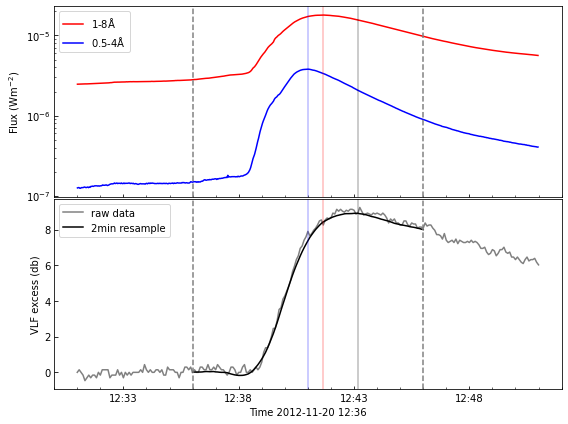

In [33]:
plot_flare(15)